<a href="https://colab.research.google.com/github/JacobBeallor/GAN/blob/master/MNIST_LSGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSGAN for MNIST
(Least squares GAN)

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import GradientTape
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Dropout, Flatten, Reshape, ReLU
from tensorflow.keras.optimizers import Adam

# !pip install imageio
from IPython import display
import time
import glob
import imageio
import os
import PIL

## Loading the dataset and setup

In [0]:
def load_dataset(bufferSize, batchSize=128):
  (trainIm, trainL), (_, _) = tf.keras.datasets.mnist.load_data()
  trainIm = trainIm.reshape((trainIm.shape[0], 28, 28, 1)).astype('float32')
  trainIm = (trainIm - 127.5) / 127.5 # rescale to [-1,1] range

  trainDataset = tf.data.Dataset.from_tensor_slices(trainIm).shuffle(bufferSize).batch(batchSize)

  return trainDataset

In [4]:
bufferSize = 60000
batchSize = 128
trainDataset = load_dataset(bufferSize, batchSize)

latent_dim = 100 # size of input noise vector
num_samples = 25 # number of samples to track generator progress
seed = tf.random.normal([num_samples, latent_dim])

genOpt = Adam(lr = 0.0002) # generator optimizer
disOpt = Adam(lr = 0.0002) # discriminator optimizer

11493376/11490434 [==============================] - 0s 0us/step


## Defining the generator

In [0]:
def buildGenerator():
  input_noise = Input(shape = (latent_dim, ))

  model = Dense(7*7*256)(input_noise)
  model = BatchNormalization()(model)
  model = ReLU()(model)

  model = Reshape((7,7,256))(model)

  model = Conv2DTranspose(128, kernel_size = (4,4), strides = (2,2), padding = 'same')(model)
  model = BatchNormalization()(model)
  model = ReLU()(model)

  model = Conv2DTranspose(64, kernel_size = (4,4), strides = (2,2), padding = 'same')(model)
  model = BatchNormalization()(model)
  model = ReLU()(model)
  # use tanh activation so pixel outputs are in [-1,1] range
  output_layer = Conv2DTranspose(1, kernel_size = (7,7), activation='tanh', padding='same')(model) 

  generator = Model(input_noise, output_layer, name = 'Generator')
  assert generator.output_shape == (None, 28, 28, 1)
  
  return generator

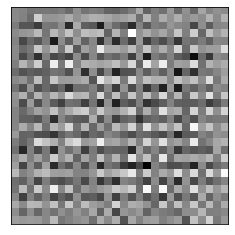

In [6]:
# Testing the generator
test_generator = buildGenerator()

noise = tf.random.normal([1, 100])
generated_image = test_generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Defining the discriminator

In [0]:
def buildDiscriminator():
  input_image = Input(shape = (28,28,1))

  model = Conv2D(64, (4,4), strides=(2, 2), padding='same')(input_image)
  model = BatchNormalization()(model)
  model = LeakyReLU(0.2)(model)

  model = Conv2D(128, (4,4), strides=(2, 2), padding='same')(model)
  model = BatchNormalization()(model)
  model = LeakyReLU(0.2)(model)

  model = Flatten()(model)
  output_layer = Dense(1, activation='linear')(model)

  discriminator = Model(input_image, output_layer, name = 'Discriminator')
  
  return discriminator

## Create the loss functions

In [0]:
# Potentially give separate weightings
mse = tf.keras.losses.MeanSquaredError()

def discriminatorLoss(real_output, fake_output):
  # Mean squared error loss
  real_loss = mse(tf.ones_like(real_output), real_output)
  fake_loss = mse(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  pred_outputs = tf.concat([real_output, fake_output], axis = 0)
  true_outputs = tf.concat([tf.ones_like(real_output), tf.zeros_like(fake_output)], axis = 0)
  acc = tf.keras.metrics.binary_accuracy(tf.transpose(true_outputs), tf.transpose(pred_outputs), threshold = 0.5)

  return total_loss, acc
  
def generatorLoss(fake_output):
  gen_loss = mse(tf.ones_like(fake_output), fake_output)
  
  return gen_loss

In [0]:
def progress_update(model, epoch, seed, genLosses, disLosses, disAcc):
  generated_images = model(seed, training = False)
  # plot generated images
  plt.figure(figsize = (5,5))
  for i in range(generated_images.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(generated_images[i, :, :, 0]*127.5 + 127.5, cmap=plt.cm.binary)
      plt.axis('off')

  plt.savefig('imageAtEpoch{:04d}.png'.format(epoch))
  plt.show()

  plt.figure(figsize=(15,12))
  epochs_idx = range(1, len(genLosses) + 1)
  plt.subplot(2,1,1)
  plt.plot(epochs_idx, genLosses, label = 'Generator loss')
  plt.plot(epochs_idx, disLosses, label = 'Discriminator loss')
  plt.xlabel('Epoch')
  plt.legend(loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(epochs_idx, disAcc, label = 'Discriminator acc.')
  plt.xlabel('Epoch')
  plt.legend(loc = 'best')

  plt.show()

## Create the training procedures

In [0]:
# @tf.function
def trainStep(real_images):
  noise_samples = tf.random.normal([batchSize, latent_dim])

  with GradientTape() as genTape, GradientTape() as disTape:
    # Generate fake images from noise samples
    generated_images = generator(noise_samples, training = True)
    # Use discriminator on real and fake images
    realOutput = discriminator(real_images, training = True)
    fakeOutput = discriminator(generated_images, training = True)
    # compute losses
    genLoss = generatorLoss(fakeOutput)
    disLoss, disAcc = discriminatorLoss(realOutput, fakeOutput)
  # compute gradients
  gen_gradients = genTape.gradient(genLoss, generator.trainable_variables)
  dis_gradients = disTape.gradient(disLoss, discriminator.trainable_variables)
  # apply gradients
  genOpt.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disOpt.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))

  return genLoss, disLoss, disAcc

In [0]:
def train(dataset, epochs=200):
  genLosses, disLosses, disAcc = [], [], []

  for epoch in range(epochs):
    start_time = time.time()
    genLossEpoch = []
    disLossEpoch = []
    disAccEpoch = []

    # iterate through image batches
    for image_batch in dataset:
      genLossBatch, disLossBatch, disAccBatch = trainStep(image_batch)
      
      genLossEpoch.append(genLossBatch)
      disLossEpoch.append(disLossBatch)
      disAccEpoch.append(disAccBatch)

    genLosses.append(np.mean(genLossEpoch))
    disLosses.append(np.mean(disLossEpoch))
    disAcc.append(np.mean(disAccEpoch))

    progress_update(generator, epoch + 1, seed, genLosses, disLosses, disAcc)  
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))
    display.clear_output(wait = True)

  # Generated images at end of training
  display.clear_output(wait = True)
  progress_update(generator, epochs, seed, genLosses, disLosses, disAcc)  

  return genLosses[-1], disLosses[-1], disAcc[-1]

## Build it!

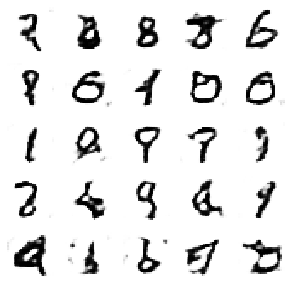

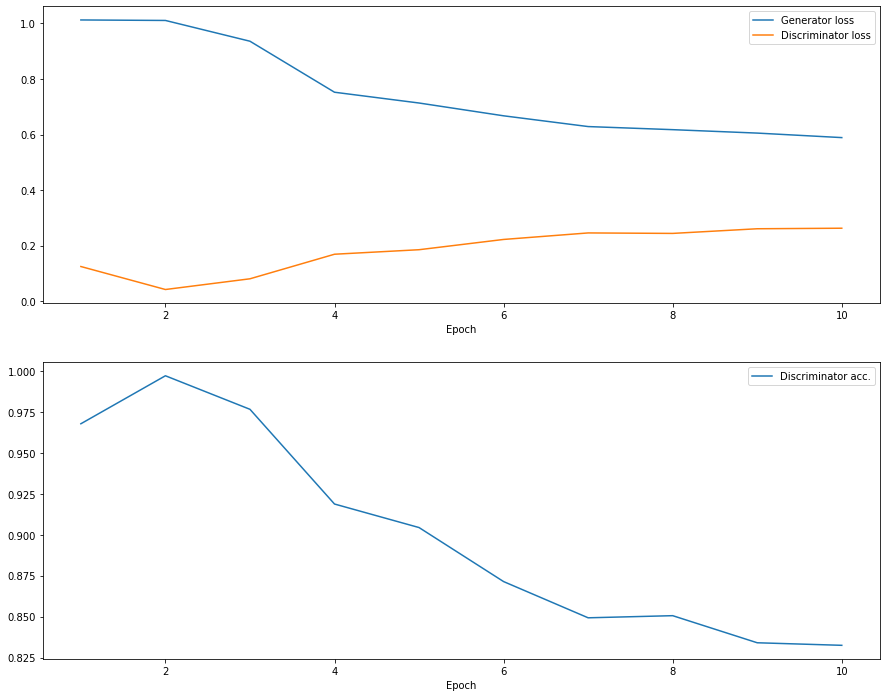

Time for epoch 10 is 44.37839961051941 sec


In [0]:
generator = buildGenerator()
discriminator = buildDiscriminator()
epochs = 200

gLoss, dLoss, dAcc = train(trainDataset, epochs = epochs)
print('Generator loss: {}\nDiscriminator loss: {}'.format(gLoss, dLoss))

# save generator model
g_name = 'generator_at_epoch_{:04d}'.format(epochs)
generator.save(g_name, save_format = tf)

# save discriminator model
d_name = 'discriminator_at_epoch_{:04d}'.format(epochs)
discriminator.save(d_name, save_format = tf)

## Create GIF of results

In [0]:
anim_file = 'LSGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    if i % 4 == 0:
      image = imageio.imread(filename)
      writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
else:
  print('IPython version too old.')

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)